In [1]:
import os
path = os.getcwd()
os.chdir('..')
from deepnotes import *
os.chdir(path)
import numpy as np
import matplotlib.pyplot as plt
# 使用Pytorch验算卷积和池化的梯度
import torch
import torch.nn as nn
import torch.nn.functional as F

### 为什么使用卷积
我们前一课学习了如何使用全连接网实现最简单的图像识别和分类, 尽管MNIST是非常容易训练的数据集, 但亲自开发一个可用的AI还是很激动人心的. 但是使用全连接网络虽然能解决很多传统机器学习方法面向的问题, 比如简单的模式分类和函数拟合. 但是设想一下, 我们实际要面对的可不是MNIST这种简单数据集, 而是特征更丰富, 分辨率更高的真实图像, 我们在网络上随便找一找就能找到大把的1000x800量级的图片. 如果我们把这种图片用来训练神经网络, 那么我们仅在第一层需要的参数就会达到1000x800xhidden size那么多, 这几乎是不可能接受的. 尽管我们也可以用预处理的方式降低分辨率, 但是这不免会丢失很多本应有的特征. 为此我们提出了二维卷积的方法帮助我们在图像中提取特征, 同时用池化方法实现图像压缩和数据降维.  
![conv.gif](conv.gif)
![edge_detection.jpg](edge_detection.jpg)
上图是卷积运算的演算法, 以及某种卷积核作用于图像后的结果. 卷积运算可以提取图像的高级特征, 比如上面的卷积就能实现边缘检测的工作. 如果我们用级联的卷积核形成卷积层, 它还能得到某些更高级的特征. 比如我们可能在上面的这种特征图上再做卷积, 得到横线的边缘和竖线的边缘. 再卷积可能就能识别直角边缘的特征.  
另外, 卷积并不是像上面那样只能操作一维图像, 通常我们的输入图像是RGB的三通道图像. 那么我们的卷积实际上是一个同为3维的卷积核按上图的方式滑动, 然后把这三个通道卷积运算得到的1维特征图相加. 如果我们用N个这样的3维卷积核把图片做N次卷积, 就能得到N通道的特征图. 那么下次卷积, 每个卷积核的维度就必须是N维, 如此类推.  
卷积运算conv2d接收C维的特征图, 尺度为NxCxHxW. 卷积核的数量为FN, 通道数为C, 尺寸filter size自主给定, 步长stride一般为1. 输出特征图为$N*FN*\frac{(H-size)+1}{stride}*\frac{(W-size)+1}{stride}$.
![conv_net.jpg](conv_net.jpg)
上图就是卷积神经网络的基本架构, 我们用这种方式实现特征的快速提取, 并用这些特征来进行模式分类, 分类任务就交给全连接层进行.  
### Im2col
虽然我们上面的图是把卷积核一步一步移动, 一步一步点积并求和, 但是实际实现时我们并不会用for循环来做这件事情, 我们通常的做法是选择最能并行化的方式, 把卷积运算转为矩阵运算. 因为今天的硬件运算性能的提高已经不是以电子器件的尺度和频率取胜了, 而是以更高程度的并行化加速运算. 把卷积转为矩阵乘法的方式如下图.
![im2col.jpg](im2col.jpg)
$$COL = im2col(IM_i) $$
$$IM_o = COL\cdot FCOL+b$$
当然执行完矩阵运算后, 这还不是结束.我们conv2d输出的是特征图, 所以我们还要有一个把矩阵重塑成NxCxHxW的特征图的reshape和permute操作.
### conv2d的反向传播
既然卷积可以写成矩阵乘法, 那么矩阵乘法的求导一样适用于卷积运算. 我们把卷积核展开成列向量, 与图像的col矩阵做乘法, 每个列向量的元素和卷积核中的元素有一一对应的关系, 那么我们保存卷积核时也不必用2d的形式保存, 而可以用列向量来保存. 这样只需要用矩阵乘法的求导方法计算FM和b的导数即可 $$\frac{\partial L}{\partial FCOL} = COL^T \cdot \frac{\partial L}{\partial IM_o} $$
$$\frac{\partial L}{\partial b} = SUMROW\frac{\partial L}{\partial IM_o} $$
比较麻烦的是计算损失函数关于输入图像的导数, 也就是反向传播. 我们前向传播使用im2col的方法得到一张把原图像im中的元素反复使用并填充到对应位置的矩阵COL, 我们计算完矩阵COL的导数后还需要一个col2im的逆变换把它变成图像导数. 这个col2im其实就是im2col的逆操作, 原来是怎样拆分矩阵的, 现在就怎样把它拼装回去. 这个过程中会有重叠的存在, 因此处理时要格外小心. 
$$ \frac{\partial L}{\partial COL} = \frac{\partial L}{\partial IM_o} \cdot FCOL^T $$
$$ \frac{\partial L}{\partial W} = col2im(\frac{\partial L}{\partial COL}) $$

In [2]:
conv1 = nn.Conv2d(3,2,3,1,1)
conv2 = Conv2d(in_channels=3, out_channels=2, kernel_size = 3,
               stride=1, padding=1)
conv2.weights = conv1.weight.data.numpy()
conv2.bias = conv1.bias.data.numpy()

x_train = torch.randn(2,3,4,4)
x_train_numpy = x_train.data.numpy()
x_train.requires_grad = True
y_train = torch.randn(2,2,4,4)
y_train_numpy = y_train.data.numpy()

out = conv1(x_train)
loss = F.mse_loss(out,y_train,reduction='sum')
loss.backward()

out = conv2(x_train_numpy)
dx = conv2.backward(2*(out-y_train_numpy))

print('dx:\n',x_train.grad-torch.FloatTensor(dx))
print('dw:\n',conv1.weight.grad-torch.FloatTensor(conv2._dw))
print('db:\n',conv1.bias.grad-torch.FloatTensor(conv2._db))

pool1 = nn.MaxPool2d(2,2)
pool2 = MaxPool2d(2,2)

x_train = torch.randn(2,3,4,4)
x_train_numpy = x_train.data.numpy()
x_train.requires_grad = True
y_train = torch.randn(2,3,2,2)
y_train_numpy = y_train.data.numpy()

out = pool1(x_train)
loss = F.mse_loss(out,y_train,reduction='sum')
loss.backward()

out = pool2(x_train_numpy)
dx = pool2.backward(2*(out-y_train_numpy))

print('dx:\n',x_train.grad-torch.FloatTensor(dx))

dx:
 tensor([[[[ 0.0000e+00, -1.1921e-07,  0.0000e+00, -3.7253e-09],
          [ 0.0000e+00,  2.3842e-07,  5.2154e-08,  5.9605e-08],
          [-5.9605e-08,  0.0000e+00, -1.1921e-07,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  1.4901e-08,  7.4506e-08]],

         [[-5.9605e-08,  0.0000e+00,  1.4901e-08,  2.9802e-08],
          [-5.9605e-08, -1.1921e-07,  2.9802e-08,  5.9605e-08],
          [ 5.9605e-08,  0.0000e+00,  2.3842e-07,  0.0000e+00],
          [ 0.0000e+00,  1.1921e-07,  3.7253e-08,  2.9802e-08]],

         [[-1.1921e-07,  0.0000e+00, -1.1921e-07,  5.9605e-08],
          [ 1.1921e-07,  1.1921e-07,  0.0000e+00,  1.1921e-07],
          [ 1.1921e-07,  2.3842e-07, -4.7684e-07, -1.1921e-07],
          [-5.9605e-08,  0.0000e+00, -4.7684e-07,  0.0000e+00]]],


        [[[ 5.9605e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.1921e-07,  5.9605e-08, -5.9605e-08, -1.1921e-07],
          [ 0.0000e+00, -3.7253e-08, -1.1921e-07, -1.1176e-08],
          [ 0.0000e+00,  2.

### 任务:搭建面向CIFAR-10的CNN分类器
使用上面写好的卷积层和池化层, 还有之前实现过的激活函数和softmax, 线性层等, 实现简单的卷积神经网络, 并用反向传播训练网络. base line是在cifar-10上达到60%的准确率. 一种最基本的模型架构为:  
(input) - Conv1 - ReLU - Pooling - Conv2 - ReLU - Pooling - FC1 - ReLU - FC2 - (output)  
其中卷积层使用5x5的size, Conv1的通道数为6, Conv2的通道数为16, 如果希望能让模型做得更好, 可以适当增加卷积层数和通道数, 当然相对的需要的内存和训练时间也更多. 一种VGG型的卷积网络搭建方法是, 用两层3x3的卷积核代替5x5的卷积核. 这样使用的参数更少而且层数更深, 更容易提取高级特征来让CNN学得更好. 

In [3]:
import tensorflow as tf

# load cifar-10 dataset
(x_train_origin,t_train_origin),(x_test_origin,t_test_origin) = tf.keras.datasets.cifar10.load_data()

x_img_train_normalize = x_train_origin.astype('float32') / 255.0
x_img_test_normalize = x_test_origin.astype('float32') / 255.0
y_img_train = t_train_origin.flatten()
y_img_test = t_test_origin.flatten()

batch_size = 100
train_loader = DataLoader(x_img_train_normalize,y_img_train,batch_size)
test_loader = DataLoader(x_img_test_normalize,y_img_test,batch_size)

170500096/170498071 [==============================] - 6s 0us/step


Epoch [1/10], Step [50/500], Loss: 2.1858
Epoch [1/10], Step [100/500], Loss: 1.7130
Epoch [1/10], Step [150/500], Loss: 1.5685
Epoch [1/10], Step [200/500], Loss: 1.4656
Epoch [1/10], Step [250/500], Loss: 1.3486
Epoch [1/10], Step [300/500], Loss: 1.2898
Epoch [1/10], Step [350/500], Loss: 1.2907
Epoch [1/10], Step [400/500], Loss: 1.2103
Epoch [1/10], Step [450/500], Loss: 1.2200
Epoch [1/10], Step [500/500], Loss: 1.1171
Accuracy of the network on the 10000 test images: 62.23 %
Epoch [2/10], Step [50/500], Loss: 1.0729
Epoch [2/10], Step [100/500], Loss: 1.0632
Epoch [2/10], Step [150/500], Loss: 1.0482
Epoch [2/10], Step [200/500], Loss: 1.0393
Epoch [2/10], Step [250/500], Loss: 0.9636
Epoch [2/10], Step [300/500], Loss: 0.9367
Epoch [2/10], Step [350/500], Loss: 0.9693
Epoch [2/10], Step [400/500], Loss: 0.9284
Epoch [2/10], Step [450/500], Loss: 0.9584
Epoch [2/10], Step [500/500], Loss: 0.8768
Accuracy of the network on the 10000 test images: 66.97 %
Epoch [3/10], Step [50/500

Text(0.5, 1.0, 'Train loss(Cross Entropy)')

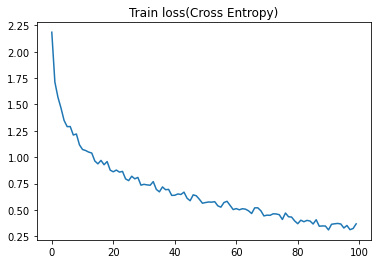

In [5]:
num_epochs = 10
total_step = len(train_loader)

# 简单的三层卷积神经网络
# [conv->relu]->pool x 3 -> fc -> relu -> fc -> softmax
model = Sequential(
    Conv2d(in_channels=3, out_channels=32, kernel_size = 3,
           stride=1,padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2,stride=2),
    Conv2d(in_channels=32, out_channels=64, kernel_size = 3,
           stride=1,padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2,stride=2),
    Conv2d(in_channels=64, out_channels=128, kernel_size = 3,
           stride=1,padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2,stride=2),
    Flatten(),
    Linear(128*4*4,128),
    ReLU(),
    Linear(128,10),
)
loss_func = CrossEntropyLossWithSoftMax(10)
optimizer = Adam(0.001)
model.apply_optim(optimizer)

loss_list = []
log_step = 50

for epoch in range(num_epochs):
    running_loss = 0.
    for i in range(total_step):
        x,y = train_loader.get_batch()
        x = x.transpose(0,3,1,2)
        # Forward pass
        logits = model(x)
        # calculate loss
        loss,dlo
        gits = loss_func(logits,y)
        # Backward
        model.zero_grad()
        model.backward(dlogits)
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        
        if (i+1) % log_step == 0:
            running_loss/=log_step
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, running_loss))
            loss_list.append(running_loss)
            running_loss = 0.
            
    correct = 0
    total = 0

    for i in range(len(test_loader)):
        x,y = test_loader.get_batch()
        x = x.transpose(0,3,1,2)
        logits = model(x)
        predicted = np.argmax(logits, axis = 1)
        total += y.shape[0]
        correct += (predicted == y).sum()

    print('Accuracy of the network on the 10000 test images: %.2f %%'%(100 * correct / total))

plt.plot(loss_list)
plt.title('Train loss(Cross Entropy)')